##### Load all datasets

In [19]:
import warnings
import random 
import os
import pandas as pd 
import numpy as np 
import glob
import duckdb
import geopandas as gpd 
from scipy.stats import ranksums
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests

class DataLoader: 

    ZCTA_geo_datapath = '../datasets/State-zip-code-GeoJSON/*.json'
    claims_data_path='../datasets/Flood-insurance/FimaNfipClaims.csv'
    zillow_data_path='../datasets/Zillow-home-prices/zillow_realestate_ts_zip.csv'
    irs_data_path='../datasets/Demographics/22irs.csv'
    zip_geos_pd='json_to_dfs_no_geom'

    FRED_api_endpoint = 'https://api.stlouisfed.org/fred/series/observations'
    FRED_api_key = '8fd9759bac0caf671d3462eed0b34d68'

    DUCKDB_location = '../datasets/combined_data.db'
    
    def __init__(self): 
        try:
            self.con = self.initialize_ddb()
        except Exception as e: 
            print(e) 
            pass 

    def retrieve_regional_data_snapshot(self, region_str):
        
        assert hasattr(self, 'con') 

        df = self.con.sql(f"select * from zillow_home_prices where Metro ilike '%{region_str}%'").df()
        cols = ['RegionName', 'Metro','CountyName'] + [i for i in df.columns if len(i.split('-')) == 3]
        zillow_df = df[cols]
        zillow_df = zillow_df.rename(
            columns={
                'RegionName':'zip'
            }
        )
        
        zip_codes = zillow_df['zip'].unique()

        zips_str = ','.join(zip_codes)
        irs_df = self.con.sql(f'select * from irs_zip where zip in ({zips_str})').df()
        claims_df = self.con.sql(
            f'''
             select * 
             from (select * from nfip_claims_zip where zip in ({zips_str})) nfip
             inner join zip_geos using (zip)
             order by dateOfLoss
             ;
             '''
        ).df()

        return {
            'ZILLOW' : zillow_df, 
            'IRS_SOCIO': irs_df, 
            'NFIP_CLAIMS': claims_df
        }

    def retrieve_macroeconomic_data(self):

        if hasattr(self, 'macro_data'):
            return self.macro_data 
            
        econ_dataset_codes = {
            'fed_funding_rate':'DFF', 
            '30yr_mortgage_avg':'MORTGAGE30US', 
            '15yr_mortgage_avg':'MORTGAGE15US',  
            'consumer_price_idx':'CPIAUCSL', 
            'real_disposable_income':'DSPIC96', 
            'real_disp_income_per_capita':'A229RX0'
        }

        data=[]
        for col, code in econ_dataset_codes.items(): 
            params = {
                'series_id': code, 'api_key': self.FRED_api_key, 'file_type': 'json'
            }
            try: 
                resp = requests.get(self.FRED_api_endpoint, params=params).json()
                resp_df = pd.DataFrame(resp['observations'])\
                    .drop(columns=['realtime_start','realtime_end'])\
                    .rename(columns={'value':col})
                resp_df[col] = resp_df[col].astype(float)
                resp_df['date'] = pd.to_datetime(resp_df['date'])
                resp_df['year'] = resp_df['date'].dt.year
                resp_df['month'] = resp_df['date'].dt.month 
                resp_df_monthly = resp_df\
                    .drop(columns=['date'])\
                    .groupby(['year','month'])[[col]].mean()
            
                data.append(resp_df_monthly)
            except Exception as e: 
                print(e)
                continue
                        
        cct = pd.concat(data,axis=1)\
            .sort_values(by=['year','month'])\
            .reset_index()
        cct['date'] = cct['year'].astype(str) + '-' + cct['month'].astype(str) 
        cct['date'] = pd.to_datetime(cct['date']) 
        cct = cct.set_index('date')
        self.macro_data = cct
        return cct
        
    def initialize_ddb(self):
        
       # if os.path.exists(self.DUCKDB_location): 
          #  return duckdb.connect(self.DUCKDB_location)
            
        base_query = '''
        drop table if exists nfip_claims
        ;

        create table nfip_claims as 
        select  
            id,
            asOfDate, 
            dateOfLoss,
            policyCount as insuredUnits, 
            baseFloodElevation, 
            ratedFloodZone, 
            occupancyType, 
            originalConstructionDate, 
            originalNBDate, 
            coalesce(amountPaidOnBuildingClaim,0) +                  
            coalesce(amountPaidOnContentsClaim,0) +                  
            coalesce(amountPaidOnIncreasedCostOfComplianceClaim,0) as totalClaim, 
            coalesce(totalBuildingInsuranceCoverage,0) + 
            coalesce(totalContentsInsuranceCoverage,0) as totalCovered, 
            coalesce(buildingDamageAmount,0) + coalesce(contentsDamageAmount,0) as totalDamageLoss, 
            buildingDeductibleCode, 
            contentsDeductibleCode,
            causeOfDamage, 
            buildingPropertyValue, 
            floodproofedIndicator, 
            floodEvent, 
            state, 
            reportedZipCode, 
            censusTract, 
            latitude, 
            longitude
        from read_csv('{claims_data_path}', strict_mode=False)
        ;

        drop table if exists nfip_claims_zip 
        ; 

        create table nfip_claims_zip as 
        select 
            reportedZipCode as zip, 
            state,
            floodEvent,
            dateOfLoss,
            count(id) as claimCounts,
            sum(insuredUnits) as policyCounts, 
            sum(totalClaim) as totalClaimZip, 
            sum(totalDamageLoss) as totalLossesZip
        from nfip_claims
        where dateOfLoss >= '2000-01-01'
        group by 1,2,3,4
        order by 5 desc
        ;

        drop table if exists irs_zip
        ;

        create table irs_zip as 
        select 
            STATE, 
            ZIPCODE as zip, 
            AGI_STUB as adjGrossIncomeTaxBracket,
            N1 as numberTaxReturns, 
            MARS1 as singleStatusTotalReturns, 
            MARS2 as marriedStatusTotalReturns, 
            MARS4 as HoHTotalReturns, 
            N2 as totalIndividuals,
            VITA as volunteerAssistedReturns, 
            ELDERLY as elderlyReturns, 
            A00100 as adjustedGrossIncome, 
            A02650 as totalIncome, 
            N00200 as returnsTotalwSalariesWages, 
            N00300 as returnsTotalTaxableInterest, 
            A00300 as taxableInterestAmt,
            SCHF   as returnsTotalFarm, 
            A18450 as stateLocalSalesTaxTotal, 
            N18500 as realEstateTaxTotal, 
            N18800 as returnsTotalPersonalPropertyTax, 
            A18800 as propertyTaxAmtTotal, 
            N19300 as returnsTotalMortgageInterestPaid, 
            A19300 as mortgageInterestPaidTotal,
            N07225 as returnsDependentCareCredit, 
            A07225 as dependentCareCreditTotal, 
            N07230 as returnsEducationCredit, 
            A07230 as educationCreditTotal, 
            N85770 as returnsPremiumsCredit, ---aids in offsetting health insurance premiums
            A85770 as premiumsCreditTotal, 
        from read_csv('{irs_data_path}', strict_mode=False)
        ;
    
        drop table if exists zillow_home_prices
        ;

        create table zillow_home_prices as 
        select * 
        from read_csv('{zillow_data_path}', strict_mode=False)
        ;

        drop table if exists zip_geos
        ;

        create table zip_geos as 
        select * 
        from {zip_geos_pd}
        ;
        '''

        read_jsons = [
            gpd.read_file(gj)[['ZCTA5CE10','geometry','ALAND10','AWATER10']] 
            for gj in glob.glob(self.ZCTA_geo_datapath)
        ]
        json_to_dfs = pd.concat(read_jsons)
        json_to_dfs = json_to_dfs.rename(
                columns={
                    'ZCTA5CE10':'zip', 
                    'ALAND10':'landAreaTotal', 
                    'AWATER10':'waterAreaTotal'
                }
            )
        json_to_dfs_no_geom = json_to_dfs.drop(columns=['geometry'])
        con = duckdb.connect(self.DUCKDB_location)
        con.sql(
            base_query.format(
                claims_data_path=self.claims_data_path,
                zillow_data_path=self.zillow_data_path, 
                irs_data_path=self.irs_data_path, 
                zip_geos_pd=self.zip_geos_pd
            )
        )
        return con
        

dl=DataLoader()

IO Error: Could not set lock on file "/Users/devenbarth/climate-effects-on-real-estate/guided_study_climate_realestate/causal-inference/../datasets/combined_data.db": Conflicting lock is held in /opt/anaconda3/envs/cusp_python_3_9/bin/python3.9 (PID 90677) by user devenbarth. See also https://duckdb.org/docs/connect/concurrency


In [20]:
dl.con.close()

AttributeError: 'DataLoader' object has no attribute 'con'

In [15]:
dl.retrieve_macroeconomic_data()

,year,month,fed_funding_rate,30yr_mortgage_avg,15yr_mortgage_avg,consumer_price_idx,real_disposable_income,real_disp_income_per_capita
date,,,,,,,,
1947-01-01,1947,1,NaN,NaN,NaN,21.480,NaN,NaN
1947-02-01,1947,2,NaN,NaN,NaN,21.620,NaN,NaN
1947-03-01,1947,3,NaN,NaN,NaN,22.000,NaN,NaN
1947-04-01,1947,4,NaN,NaN,NaN,22.000,NaN,NaN
1947-05-01,1947,5,NaN,NaN,NaN,21.950,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-11-01,2024,11,4.638333,6.8050,6.0275,316.449,17592.4,51565.0
2024-12-01,2024,12,4.475161,6.7150,5.9300,317.603,17605.8,51581.0
2025-01-01,2025,1,4.330000,6.9580,6.1640,319.086,17661.4,51724.0


In [18]:
data=dl.retrieve_regional_data_snapshot(region_str=', NY')
data['ZILLOW'].head(5)

ConnectionException: Connection Error: Connection already closed!

In [ ]:
data['IRS_SOCIO']

,STATE,zip,adjGrossIncomeTaxBracket,numberTaxReturns,singleStatusTotalReturns,marriedStatusTotalReturns,HoHTotalReturns,totalIndividuals,volunteerAssistedReturns,elderlyReturns,...,returnsTotalPersonalPropertyTax,propertyTaxAmtTotal,returnsTotalMortgageInterestPaid,mortgageInterestPaidTotal,returnsDependentCareCredit,dependentCareCreditTotal,returnsEducationCredit,educationCreditTotal,returnsPremiumsCredit,premiumsCreditTotal
0,PA,18324,1,1410.0,980.0,150.0,240.0,1950.0,0.0,350.0,...,0.0,0.0,30.0,205.0,80.0,27.0,30.0,18.0,50.0,393.0
1,PA,18324,2,1090.0,580.0,220.0,230.0,1950.0,0.0,270.0,...,0.0,0.0,0.0,0.0,320.0,371.0,70.0,84.0,70.0,590.0
2,PA,18324,3,760.0,340.0,220.0,150.0,1380.0,0.0,220.0,...,0.0,0.0,50.0,361.0,250.0,506.0,50.0,67.0,30.0,202.0
3,PA,18324,4,510.0,160.0,250.0,90.0,1050.0,0.0,190.0,...,40.0,33.0,50.0,334.0,170.0,397.0,40.0,46.0,30.0,267.0
4,PA,18324,5,730.0,140.0,480.0,100.0,1700.0,0.0,230.0,...,0.0,0.0,100.0,674.0,290.0,670.0,70.0,92.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10261,NY,14905,2,920.0,620.0,140.0,140.0,1340.0,0.0,280.0,...,0.0,0.0,0.0,0.0,180.0,251.0,50.0,47.0,40.0,181.0
10262,NY,14905,3,740.0,420.0,190.0,100.0,1210.0,0.0,260.0,...,0.0,0.0,30.0,164.0,170.0,390.0,40.0,49.0,0.0,0.0
10263,NY,14905,4,520.0,210.0,240.0,60.0,1020.0,0.0,210.0,...,0.0,0.0,30.0,149.0,140.0,391.0,30.0,37.0,0.0,0.0
10264,NY,14905,5,750.0,120.0,600.0,30.0,1860.0,0.0,320.0,...,0.0,0.0,50.0,271.0,270.0,783.0,60.0,83.0,0.0,0.0


In [ ]:
data['NFIP_CLAIMS']

,zip,state,floodEvent,dateOfLoss,claimCounts,policyCounts,totalClaimZip,totalLossesZip,landAreaTotal,waterAreaTotal
0,13760,NY,None,2000-01-01,1,1.0,10928.89,11928.0,127378213,1168021
1,14433,NY,None,2000-01-03,1,1.0,0.00,0.0,171381988,827550
2,07512,NJ,None,2000-01-07,1,1.0,0.00,0.0,10213322,183463
3,11976,NY,None,2000-01-08,1,1.0,2996.00,7996.0,31784245,5836969
4,07981,NJ,None,2000-01-15,1,1.0,4008.40,5010.0,17468281,393957
...,...,...,...,...,...,...,...,...,...,...
25019,08050,NJ,None,2024-11-21,1,1.0,0.00,0.0,78847087,18080855
25020,11235,NY,None,2024-11-23,1,1.0,0.00,0.0,5816304,501713
25021,07643,NJ,None,2024-11-28,1,1.0,0.00,0.0,3822333,586726
25022,08824,NJ,None,2024-12-03,1,1.0,0.00,0.0,10044432,3288


#### Perform Causal Analysis

In [ ]:
class CausalAnalysis: 
    
    def __init__(self, dataloader, state): 
        self.dataloader = dataloader
        self.state = f', {state}'
        if not hasattr(self.dataloader, 'con'):
            self.dataloader.initialize_ddb() 
        datasets = self.dataloader.retrieve_regional_data_snapshot(self.state)
        for n, df in datasets.items():
            print(f'Instantiating dataset {n} into memory')
            setattr(self, n, df)

    ### build predictor variable
    def generate_real_estate_shiftindex(self, historical_discount_factor=0.0005):
        
        def weighting_fn(df, alpha):
            df=df.dropna()
            N=len(df)
            w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
            w_norm = w/w.sum() 
            v = 1e3*(df.T@w_norm)
            idx = v-v.mean()
            return idx
            
        ts=self.ZILLOW.set_index('zip').drop(columns=['Metro','CountyName']).T
        ts_roc = ts.diff().div(ts)
        ts_roc_qtr_smoothed = ts_roc.rolling(4).mean()
        return weighting_fn(ts_roc_qtr_smoothed, historical_discount_factor)

    ### build treatment + confounder vars
    def build_features(self):

        socioeconomic_tax_confounders = self.IRS_SOCIO.copy()
        num_rets_feats = [
            'numberTaxReturns',
            'elderlyReturns', 
            'returnsTotalwSalariesWages',
            'returnsDependentCareCredit', 
            'returnsEducationCredit'
        ] 
        piv=socioeconomic_tax_confounders.pivot(
            index='zip', columns='adjGrossIncomeTaxBracket', values='numberTaxReturns'
        )
        piv_norm = piv.div(piv.sum(axis=1),axis=0)
        grp = socioeconomic_tax_confounders.groupby('zip')[num_rets_feats].sum()
        grp = grp.div(grp['numberTaxReturns'],axis=0).drop(columns=['numberTaxReturns'])

        feature_matrix = pd.concat((piv_norm,grp),axis=1)

        risk_variables = self.NFIP_CLAIMS.copy()
        risk_variables['waterAreaProp'] = risk_variables['waterAreaTotal'] / (risk_variables['landAreaTotal']+risk_variables['waterAreaTotal'])
        zip_ = \
            risk_variables.groupby(['zip']).agg(
                numberEvents=pd.NamedAgg(column='floodEvent',aggfunc='count'), 
                totalClaims=pd.NamedAgg(column='totalClaimZip',aggfunc='sum'), 
                totalLosses=pd.NamedAgg(column='totalLossesZip',aggfunc='sum'), 
                waterAreaProp=pd.NamedAgg(column='waterAreaProp',aggfunc='max')
        )

        zip_['log(totalClaims)'] = np.log(zip_['totalClaims']+0.000001) 
        zip_['log(totalLosses)'] = np.log(zip_['totalLosses']+0.000001) 

        zip_ = zip_.drop(columns=['totalClaims','totalLosses']) 

        rfs = [
            'numberEvents', 
            'waterAreaProp', 
            'log(totalLosses)'
        ]

        st = StandardScaler()
        rf_matrix = zip_[rfs].values
        rf_matrix_st = StandardScaler().fit_transform(rf_matrix).mean(axis=1)
        zip_['risk_score'] = rf_matrix_st
        zip_['risk_group'] = rf_matrix_st > rf_matrix_st.mean()

        self.FEATURES = pd.concat((feature_matrix, zip_[['risk_group']]),axis=1).dropna()
        
        return self.FEATURES

    def calculate_propensity_scores(self, plot=False): 

        assert hasattr(self, 'FEATURES')
        prop_score_lr = LogisticRegression() 

        X = self.FEATURES.iloc[:,:-1].values
        y = self.FEATURES['risk_group'].astype(bool)

        prop_score_lr.fit(X,y) 
        self.FEATURES['propensity_score'] = prop_score_lr.predict_proba(X)[:,1]

        if plot: 
            self.FEATURES.loc[self.FEATURES['risk_group']]['propensity_score'].hist(alpha=0.5,label='risky',bins=25)
            self.FEATURES.loc[self.FEATURES['risk_group']==False]['propensity_score'].hist(alpha=0.5,label='non-risky',bins=25)
            plt.title('Propensity Score Distributions')
            plt.legend()
            plt.show()
        
    def build_matching_groups(self):

        self.calculate_propensity_scores() 

        #idk find a better way to do this, use a mathematical optimization approach? find lit. on this
        COVERED = set()
        def search_closest_match(output_idx_lst, df=self.FEATURES):
            for i in output_idx_lst[1:]:
        
                r = df.iloc[i]
                zip = r.name
        
                if r['risk_group']:
                    if zip in COVERED:
                        continue 
                    else:
                        COVERED.add(zip)
                        return zip

      #  def calc_risk_diff(r, df=zip_):
       #     zips = [
        #        r['matched_zip_nonrisky'], r['matched_zip_risky']
         #   ]
          #  diff_r = df.loc[zips]['risk_score'].diff().abs().iloc[-1]
           # return diff_r 

        dataset_match = self.FEATURES.loc[self.FEATURES['risk_group']==False][['propensity_score']]
        prop_score = self.FEATURES['propensity_score'].to_numpy().reshape(-1,1)

        nn = NearestNeighbors(n_neighbors=5, radius=0.25) 
        nn.fit(prop_score)

        control = dataset_match['propensity_score'].to_numpy().reshape(-1,1)
        _, nearest_i = nn.kneighbors(control)

        zip_matched = [
            search_closest_match(i) for i in nearest_i
        ]
        dataset_match['matched_zip_risky'] = zip_matched

        dataset_match = \
        dataset_match\
            .reset_index()\
            .drop(columns=['propensity_score'])\
            .rename(
                columns={
                    'zip':'matched_zip_nonrisky'
                }
        )

        dataset_match = dataset_match.dropna()
      #  dataset_match['risk_diff'] = dataset_match.apply(calc_risk_diff,axis=1)
        return dataset_match

    def build_treatment_effect_report(self, discount_factor, plot=False):
        
        self.matched_zips = self.build_matching_groups() 
        self.home_pr_indices = self.generate_real_estate_shiftindex(
            historical_discount_factor=discount_factor
        )
        
        def search_index(zip, s=self.home_pr_indices):
            return s.loc[zip]
    
     #   self.matched_zips['deviation_weight'] = self.matched_zips['risk_diff']/self.matched_zips['risk_diff'].mean()
     #   self.matched_zips = self.matched_zips.drop(columns=['risk_diff'])
        
        self.matched_zips['idx_nonrisky'] = self.matched_zips['matched_zip_nonrisky'].apply(search_index)
        self.matched_zips['idx_risky'] = self.matched_zips['matched_zip_risky'].apply(search_index)
        self.matched_zips['idx_diff'] = self.matched_zips['idx_risky']-self.matched_zips['idx_nonrisky']
        if plot: 
            self.matched_zips['idx_nonrisky'].hist(bins=50, alpha=0.5, label='Non-risky Price Shift Index')
            self.matched_zips['idx_risky'].hist(bins=50, alpha=0.5, label='Risky Price Shift Index')
            plt.title('Price Shifts by Zip-code Groups')
            plt.legend()
            plt.show()
            
        test_sig = ranksums(self.matched_zips['idx_nonrisky'],self.matched_zips['idx_risky'])
        
        diffs = self.matched_zips['idx_diff']
        bootstrapped_sample_dist = pd.Series([diffs.sample(n=len(diffs), replace=True).mean() for _ in np.arange(10000)])
        obs = self.matched_zips['idx_diff'].mean()
        print(f"Average Treatment Effect, Flooding effects on house prices {self.state}: {obs}")
        CI = [
            bootstrapped_sample_dist.quantile(0.025), 
            bootstrapped_sample_dist.quantile(0.975)
        ]
        self.report = {
            'State': self.state, 
            'Discount Factor': discount_factor,
            'ATE Estimate': obs, 
            'ATE Confidence Bounds (95 pct)': CI, 
            'p-value': test_sig.pvalue, 
            'Significant?': bool(test_sig.pvalue < 0.05 and obs < 0)
        }

        if plot: 
            plt.hist(bootstrapped_sample_dist, bins=50,)
            plt.title('ATE Estimation')

            plt.axvline(self.matched_zips['idx_diff'].mean(), label=f"Observed ATE: {self.matched_zips['idx_diff'].mean()}",color='red')
            plt.axvline(CI[0], label=f"95 pct CI Lower: {CI[0]}",color='red',linestyle='--')
            plt.axvline(CI[1], label=f"95 pct CI Upper: {CI[1]}",color='red',linestyle='--')
            plt.legend()
            plt.show()
        
        return self.matched_zips, self.report


In [8]:
causal_sample = CausalAnalysis(dl, state='FL')

ConnectionException: Connection Error: Connection already closed!

In [9]:
causal_sample.build_features()

,1,2,3,4,5,6,elderlyReturns,returnsTotalwSalariesWages,returnsDependentCareCredit,returnsEducationCredit,risk_group
zip,,,,,,,,,,,
32003,0.203488,0.162064,0.132994,0.112645,0.267442,0.121366,0.340843,0.768895,0.273256,0.047965,True
32008,0.322314,0.268595,0.157025,0.099174,0.128099,0.024793,0.314050,0.780992,0.235537,0.037190,False
32009,0.213836,0.220126,0.144654,0.144654,0.238994,0.037736,0.283019,0.830189,0.289308,0.031447,False
32011,0.232310,0.240320,0.157543,0.116155,0.212283,0.041389,0.257677,0.839786,0.295060,0.038718,False
32024,0.295378,0.266065,0.158963,0.099211,0.146561,0.033822,0.299887,0.793687,0.262683,0.040586,False
...,...,...,...,...,...,...,...,...,...,...,...
34987,0.195159,0.162632,0.140696,0.117247,0.272315,0.111952,0.496974,0.650530,0.183812,0.041604,False
34990,0.201479,0.141097,0.113370,0.093654,0.237831,0.212569,0.434381,0.688848,0.210721,0.034504,True
34994,0.303097,0.255531,0.151549,0.086283,0.127212,0.076327,0.378319,0.714602,0.167035,0.028761,True


In [10]:
data=causal_sample.build_treatment_effect_report(discount_factor=0.05)
data

Average Treatment Effect, Flooding effects on house prices , FL: -1.2516419982288836


(    matched_zip_nonrisky matched_zip_risky  idx_nonrisky  idx_risky  idx_diff
 0                  32008             33157      5.939223   6.957027  1.017804
 2                  32011             33351      4.363353   0.210173 -4.153180
 4                  32025             33024      2.138835   2.611886  0.473051
 5                  32033             34222     -2.306800  -4.155866 -1.849066
 7                  32040             33578      4.576710  -1.319022 -5.895732
 ..                   ...               ...           ...        ...       ...
 464                34758             33034     -0.959030   4.081130  5.040160
 466                34761             33065      1.428869  -1.965538 -3.394407
 473                34788             33982     -0.480481  -5.559163 -5.078683
 474                34797             34104      2.231103  -4.736208 -6.967311
 485                34984             32405      0.872749  -0.796260 -1.669009
 
 [229 rows x 5 columns],
 {'State': ', FL',
  'Dis

In [11]:
coastal_states = ['TX', 'LA', 'FL', 'GA', 'SC', 'NC']
dfacs = np.arange(0,1.0,0.05)
res = []
for dfac in dfacs:
    for state in coastal_states:
        causal_analysis = CausalAnalysis(dl, state=state)
        causal_analysis.build_features()
        _, re = causal_analysis.build_treatment_effect_report(
            discount_factor=dfac, 
            plot=False
        ) 
        res.append(re)

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , TX: -0.34663527695104573
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , LA: -0.06677017964921493
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , FL: -1.2827405331183055
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , GA: -0.04819922775466731
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Av

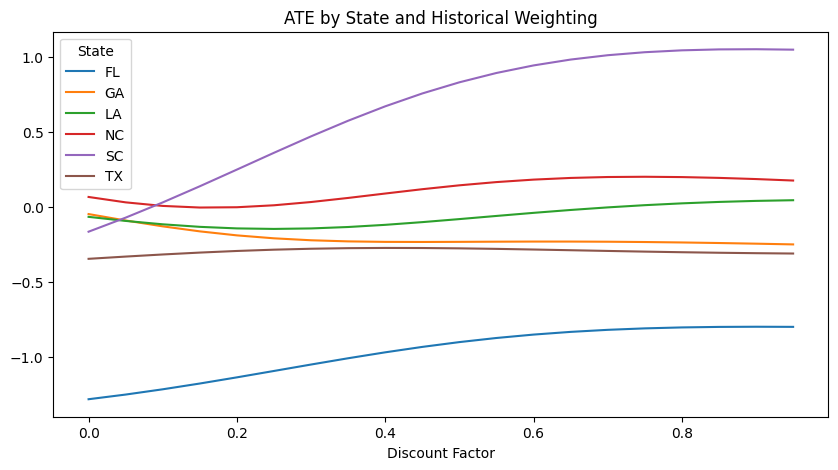

In [367]:
data=pd.DataFrame(res)
data['State'] = data['State'].str.replace(', ', '')
data.pivot(index='Discount Factor', values='ATE Estimate', columns='State').plot(title='ATE by State and Historical Weighting', figsize=(10,5))
plt.show()

In [371]:
data.loc[data['Discount Factor'] == 0.05]

,State,Discount Factor,ATE Estimate,ATE Confidence Bounds (95 pct),p-value,Significant?
6,TX,0.05,-0.331632,"[-0.7199288837656215, 0.06592832285765887]",0.060025,False
7,LA,0.05,-0.093906,"[-1.421972395989301, 1.263187802120284]",0.969828,False
8,FL,0.05,-1.251642,"[-1.7434605289614904, -0.7640619479891916]",0.000002,True
9,GA,0.05,-0.091142,"[-0.7036927423222719, 0.507720183977344]",0.969331,False
10,SC,0.05,-0.072041,"[-1.084853414004913, 0.90441538149536]",0.934877,False
11,NC,0.05,0.029867,"[-0.4178306914477093, 0.48910110465686707]",0.902389,False


In [373]:
data.loc[data['Discount Factor'] == 0.75]

,State,Discount Factor,ATE Estimate,ATE Confidence Bounds (95 pct),p-value,Significant?
90,TX,0.75,-0.298563,"[-0.866564581400055, 0.2827401925709222]",0.028813,True
91,LA,0.75,0.011072,"[-1.6200917432921607, 1.8335364408713017]",0.753736,False
92,FL,0.75,-0.810359,"[-1.2660893109390383, -0.35640409421651337]",0.000478,True
93,GA,0.75,-0.234617,"[-1.3300543602979247, 0.8632262560239728]",0.851446,False
94,SC,0.75,1.030943,"[-0.3195653706304252, 2.4412936637461793]",0.577009,False
95,NC,0.75,0.200504,"[-0.7266877690080068, 1.1070286205699953]",0.179180,False


In [2]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize']=(8,5)
states = [
    'FL','GA', 'LA', 'NC', 'SC', 'TX'
]

data_t = data.loc[data['State'].isin(states)]
data_t['err'] = data_t['ATE Confidence Bounds (95 pct)'].apply(lambda x: (x[1]-x[0])/2)
data_t = data_t.loc[data_t['Discount Factor'] == 0.05]
plt.bar(
    data_t['State'], 
    data_t['ATE Estimate'], 
    yerr=data_t['err'],
)
plt.axhline(0,color='red')
plt.title('Climate Impact Treatment Effect Estimates: Doubly Robust Learning')

NameError: name 'data' is not defined

#### Correct for inflation

In [397]:
class InflationCorrectedCausalAnalysis(CausalAnalysis): 

    def __init__(self, dataloader, state): 
        super().__init__(dataloader, state)
        self.macroeconomic_indicators = dataloader.retrieve_macroeconomic_data() 

    def generate_real_estate_shiftindex(self, historical_discount_factor=0.0005):

         def weighting_fn(df, alpha):
            df=df.dropna()
            N=len(df)
            w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
            w_norm = w/w.sum() 
            v = 1e3*(df.T@w_norm)
            idx = v-v.mean()
            return idx
             
         cpi = self.macroeconomic_indicators\
                  .loc[self.macroeconomic_indicators['year']>=2000][['consumer_price_idx']]\
                  .dropna()\
                  .iloc[1:-1,:]

         cpi['inflation_correction'] = cpi['consumer_price_idx'].iloc[0] / cpi['consumer_price_idx'] 

         ts = self.ZILLOW.set_index('zip').drop(columns=['Metro','CountyName']).T
         ts = ts.mul(cpi['inflation_correction'].to_numpy(),axis=0)
         ts_roc = ts.diff().div(ts)
         ts_roc_qtr_smoothed = ts_roc.rolling(4).mean()

         return weighting_fn(ts_roc_qtr_smoothed, historical_discount_factor)
 
res_inf = []
for dfac in dfacs:
    for state in coastal_states:
        causal_analysis = InflationCorrectedCausalAnalysis(dl, state=state)
        causal_analysis.build_features()
        _, re = causal_analysis.build_treatment_effect_report(
            discount_factor=dfac, 
            plot=False
        ) 
        res_inf.append(re)

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , TX: -0.34718571286375827
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , LA: -0.06694766835204172
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , FL: -1.2847211841081188
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , GA: -0.047872145212445504
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
A

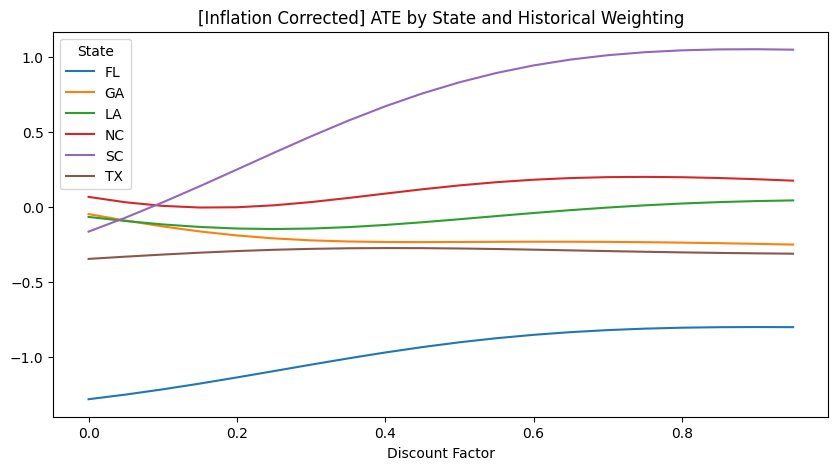

In [399]:
data=pd.DataFrame(res_inf)
data['State'] = data['State'].str.replace(', ', '')
data.pivot(index='Discount Factor', values='ATE Estimate', columns='State').plot(title='[Inflation Corrected] ATE by State and Historical Weighting', figsize=(10,5))
plt.show()

In [403]:
data.loc[data['Discount Factor'] == 0.05]

,State,Discount Factor,ATE Estimate,ATE Confidence Bounds (95 pct),p-value,Significant?
6,TX,0.05,-0.332193,"[-0.7324622878114592, 0.0617469504417154]",0.060025,False
7,LA,0.05,-0.094154,"[-1.4412847756599605, 1.2671845919689542]",0.973376,False
8,FL,0.05,-1.253687,"[-1.7425947086641196, -0.7737920586733075]",0.000002,True
9,GA,0.05,-0.090968,"[-0.705653597689471, 0.5188253230692286]",0.969331,False
10,SC,0.05,-0.071034,"[-1.0942176882627919, 0.9156438892409418]",0.934877,False
11,NC,0.05,0.030954,"[-0.4192825094379775, 0.4954619994451146]",0.900860,False
